# Backtesting Trading Strategies with Python

&copy; Ran Aroussi | [@aroussi](http://twitter.com/aroussi) | [aroussi.com](http://aroussi.com) | [github.com/ranaroussi](https://github.com/ranaroussi)

---

In [1]:
%matplotlib inline

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# set defauly plotting size
import matplotlib.pylab
matplotlib.pylab.rcParams['figure.figsize'] = (12, 7)

# trading strategy development workflow helper methods
import atw
from atw import timer

# Strategy Development Workflow

## Strategy Development Workflow

- Come up with a trading idea
- Run a **vectoried backtest** - for quick validation of ideas
- Run a **event-based backtest** - to eliminate data snooping and other pitfalls
- Optimize and Scrutinize
- Forward Testing
- Paper Trading
- Live Trading

---
## First, let's get some data to work with

In [3]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

spy = pdr.get_data_yahoo("SPY", start="2000-01-01", auto_adjust=True)

spy.columns = map(str.lower, spy.columns)
spy['return'] = spy['close'].pct_change().fillna(0)

spy.head()

,open,high,low,close,volume,return
Date,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.4375,8164300,0.000000
2000-01-04,143.531204,144.062500,139.640594,139.7500,8089800,-0.039106
2000-01-05,139.937500,141.531204,137.250000,140.0000,12177900,0.001789
2000-01-06,139.625000,141.500000,137.750000,137.7500,6227200,-0.016071
2000-01-07,140.312500,145.750000,140.062500,145.7500,8066500,0.058076


---
# <small>Quick Recap:</small><br>Vectorized vs. Event Based Backtesting

## Vectorized Backtesting

### Pros:

- Very fast - great for quickly testing ideas
- Requires much less coding compared to alternatives

### Cons:

- Danger of data snooping
- Usually cannot be used "as-is" for live trading

## Event-Based Backtesting

### Pros:

- More reliable backtesting (no look-ahead bias)
- Code can be used "as-is" for live trading

### Cons:

- Takes longer to write and run your backtest

---
# Basic Strategy Example

- BUY ON CLOSE when SPY drops 0.5% (or more)
- SELL ON CLOSE of next day

## Vectorized Backtesting

In [4]:
timer.start()

port = pd.DataFrame(spy['return'])
port['strategy'] = port[port['return'].shift(1) <= -0.005]['return']

timer.stop()


[*] Total runtime: 2.47 ms


## Event Based Backtesting

In [5]:
timer.start()

port = pd.DataFrame(spy['return'])

for ix, _ in port.iterrows():
    loc = port.index.get_loc(ix)
    if loc > 0:
        yday = port.iloc[loc - 1]
        if yday['return'] <= -0.005:
            port.loc[ix, "strategy"] = port.loc[ix, 'return']
            
timer.stop()


[*] Total runtime: 860.38 ms


### Using `atw`

In [6]:
timer.start()

port = pd.DataFrame(spy['return'])

for ix, loc in atw.iterate(port, progress=True):
    yday = port.iloc[loc - 1]
    if yday['return'] <= -0.005:
        port.loc[ix, 'strategy'] = port.loc[ix, 'return']
    
timer.stop()

[*********************100%***********************]  4376 of 4376 complete

[*] Total runtime: 4.63 s


---

# Measuring Performance

## Basic Performance Metrics

- **Sharpe Ratio** - risk adjusted return of investment
- **Max Drawdown** - max hole (and it's duration)
- **Recovery Factor** - how quickly the strategy recovers from drawdowns (net profit/max dd)
- **CAGR (Compound Annual Growth Rate)** - annualized % growth return 
- **Profit Factor** - profit from winning trades / losses from losing trades
- **Win Rate** - % of trades with a net profit > 0
- **Yearly/Monthly/Quarterly/Daily/Hourly Breakdown** - seasonality discovery
- **Avg. Return per Trade**
- **Avg. Return from Winners/Losers per Trade**
- **Total Returns**

## Eyeballing Performance

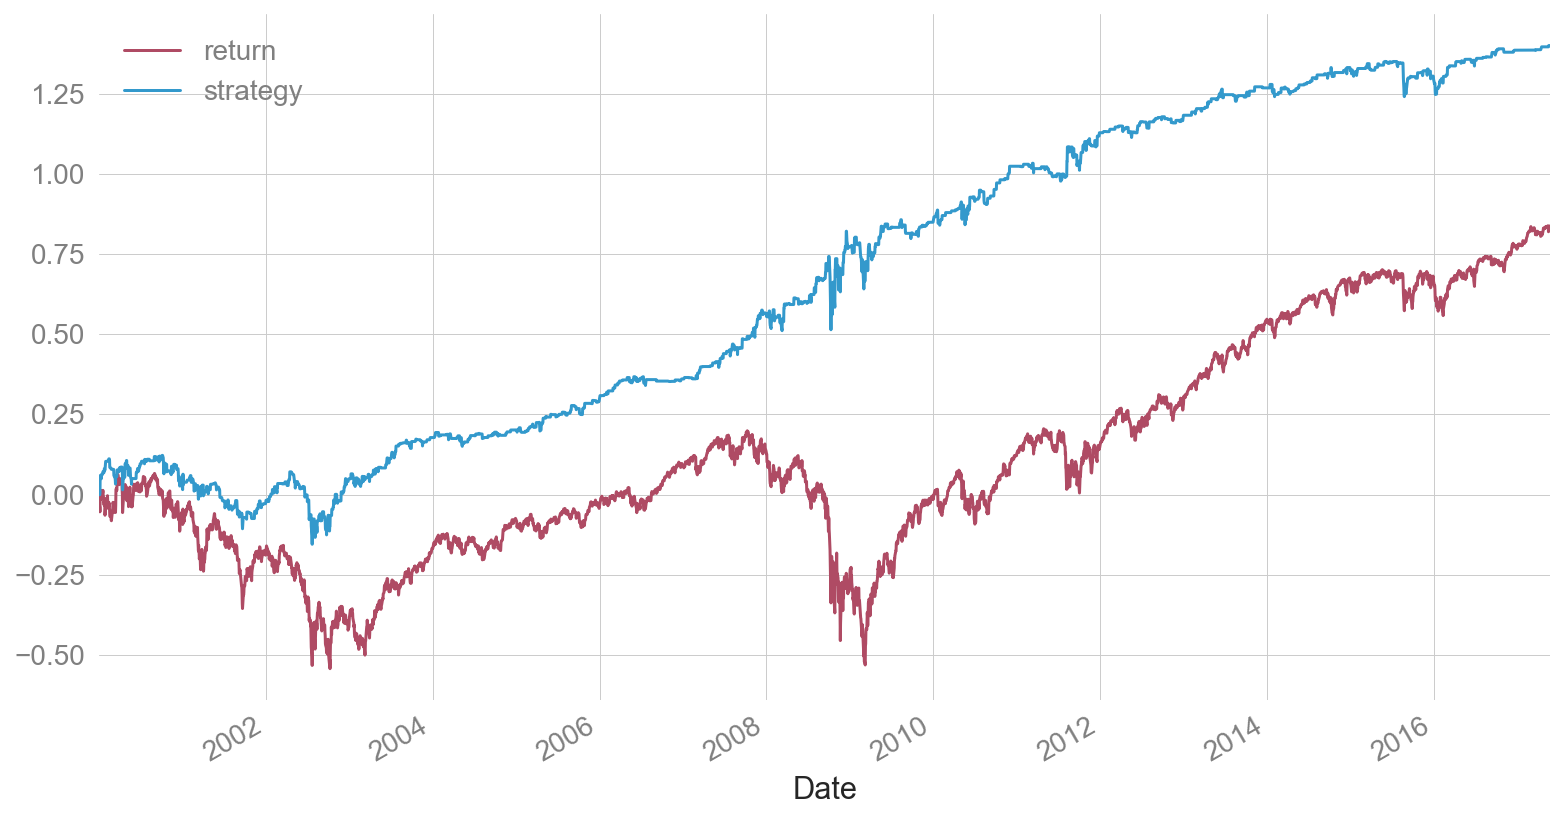

In [7]:
port.fillna(0, inplace=True)
port.cumsum().plot()

## Onto the math...

## Sharpe Ratio

<big><code><br>Sharpe(X) = (rX - Rf) / StdDev(X)</code></big>

#### Where:

- `X` is the investment
- `rX` is the average rate of the return of `X`
- `Rf` is the best available risk-free security (i.e. T-bills)
- `StdDev(X)` is the standard deviation of `rX`

In [8]:
returns = port['strategy'][port['strategy'] != 0]
sharpe = np.sqrt(252) * (np.mean(returns)) / np.std(returns)

sharpe

1.2459348946091056

## Max Drawdown

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11036dcf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1104255f8>], dtype=object)

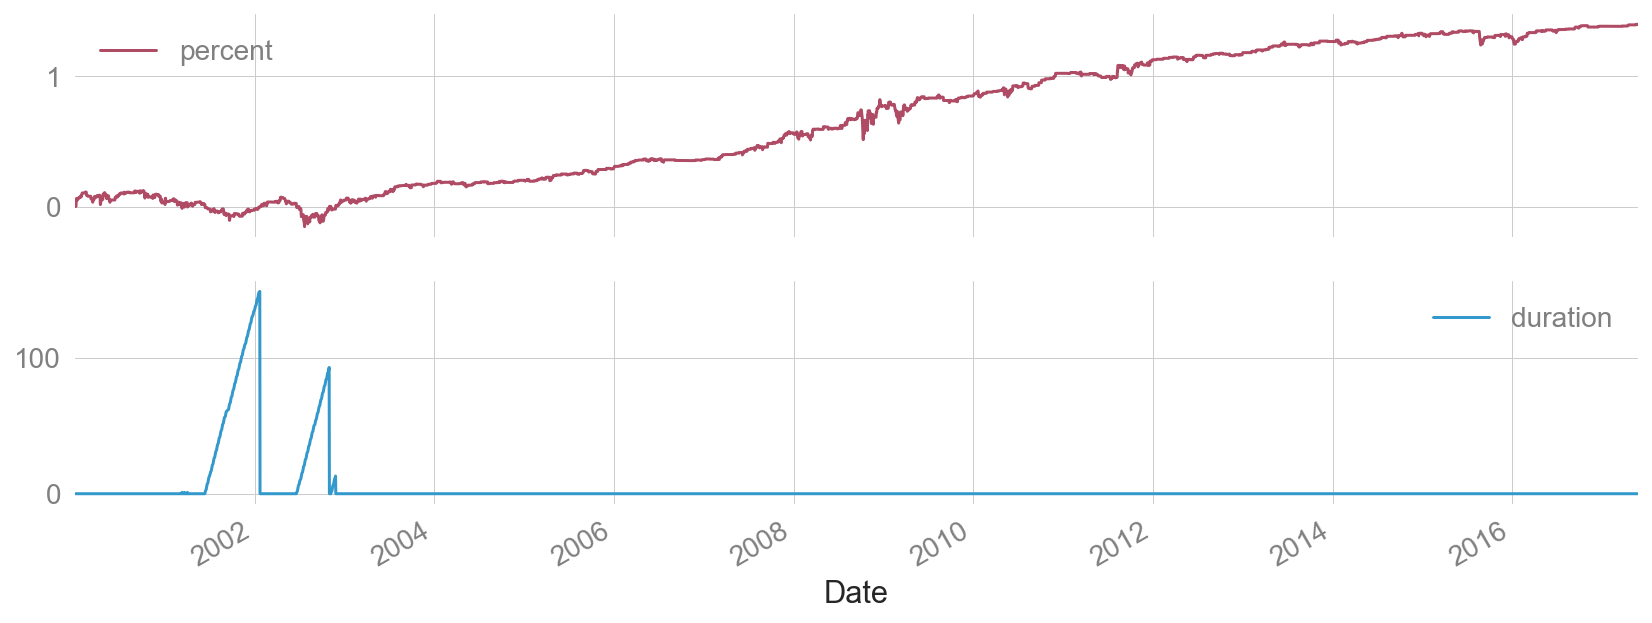

In [9]:
dd = pd.DataFrame(data={"percent": port['strategy'].cumsum()})
dd['duration'] = np.where(dd['percent'] < 0, 1, 0)
dd['duration'] = dd['duration'].groupby(
                        (dd['duration'] == 0).cumsum() ).cumcount()

dd[['percent', 'duration']].plot(figsize=(14, 5), subplots=True)

## Plotting Under Water

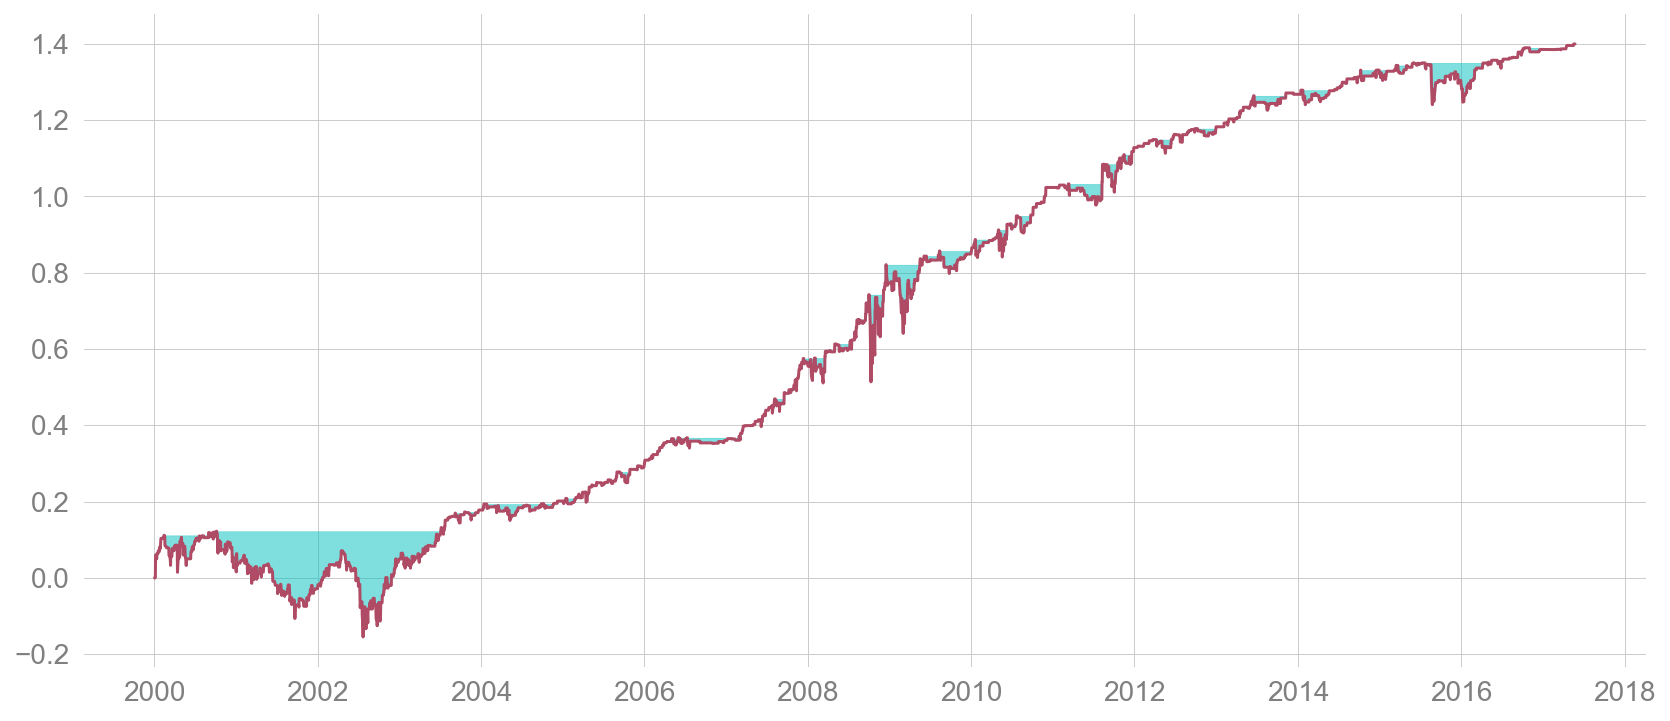

In [10]:
dd['max'] = dd['percent'].rolling(len(dd), min_periods=1).max()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dd['percent'], lw=1.5)
ax.fill_between(dd.index, dd['percent'], dd['max'], color='c', alpha=.5)

## Recovery Factor

In [11]:
max_dd = dd['percent'].min()
total_returns = sum(port['strategy'])
recovery_factor = total_returns / abs(max_dd)

recovery_factor

9.060807135217356

## CAGR (Compound Annual Growth Rate)

<big><code><br>CAGR(X) = (Vt / V0) ^ (1 / yearsX) - 1</code></big>

#### Where:

- `X` is the strategy
- `Vt` is the value at the current portfolio value
- `V0` is the value at the starting portfolio value
- `yearsX` is the total number of years the strategy ran

In [12]:
start_value = 1
end_value = 1 + sum(port['strategy'])
years = len(returns.resample("A").count())    
cagr = ((end_value / start_value) ** (1 / years)) - 1

cagr

0.049828309156602746

## Moving along... :)

In [13]:
dd = atw.drawdown(port['strategy'])

stats = [
    ("Sharpe ratio", "%.2f" % atw.sharpe(port['strategy'])),
    ("CAGR", "%.2f%%" % (atw.cagr(port['strategy']) * 100)),
    ("Win %", "%.2f%%" % (atw.win_rate(port['strategy']) * 100)),
    ("Avg. %", "%.2f%%" % (atw.avg_return(port['strategy']) * 100)),
    ("Avg. Win %", "%.2f%%" % (atw.avg_win(port['strategy']) * 100)),
    ("Avg. Loss %", "%.2f%%" % (atw.avg_loss(port['strategy']) * 100)),
    ("Profit Factor", "%.2f" % atw.profit_factor(port['strategy'])),
    ("Max DD %", "%.2f%%" % (dd['percent'].min() * 100)),
    ("DD Duration %", "%.0f days" % dd['duration'].max() ),
    ("Recovery Factor", "%.2f" % atw.recovery_factor(port['strategy'], dd['percent']))
]
 
stats = pd.DataFrame(stats, columns=['metric', 'value'])
stats.set_index(stats.columns[0], inplace=True)

print(stats)

                    value
metric                   
Sharpe ratio         1.25
CAGR                4.98%
Win %              55.76%
Avg. %              0.13%
Avg. Win %          1.09%
Avg. Loss %        -1.09%
Profit Factor        1.26
Max DD %          -15.45%
DD Duration %    149 days
Recovery Factor      9.06


## YoY Returns

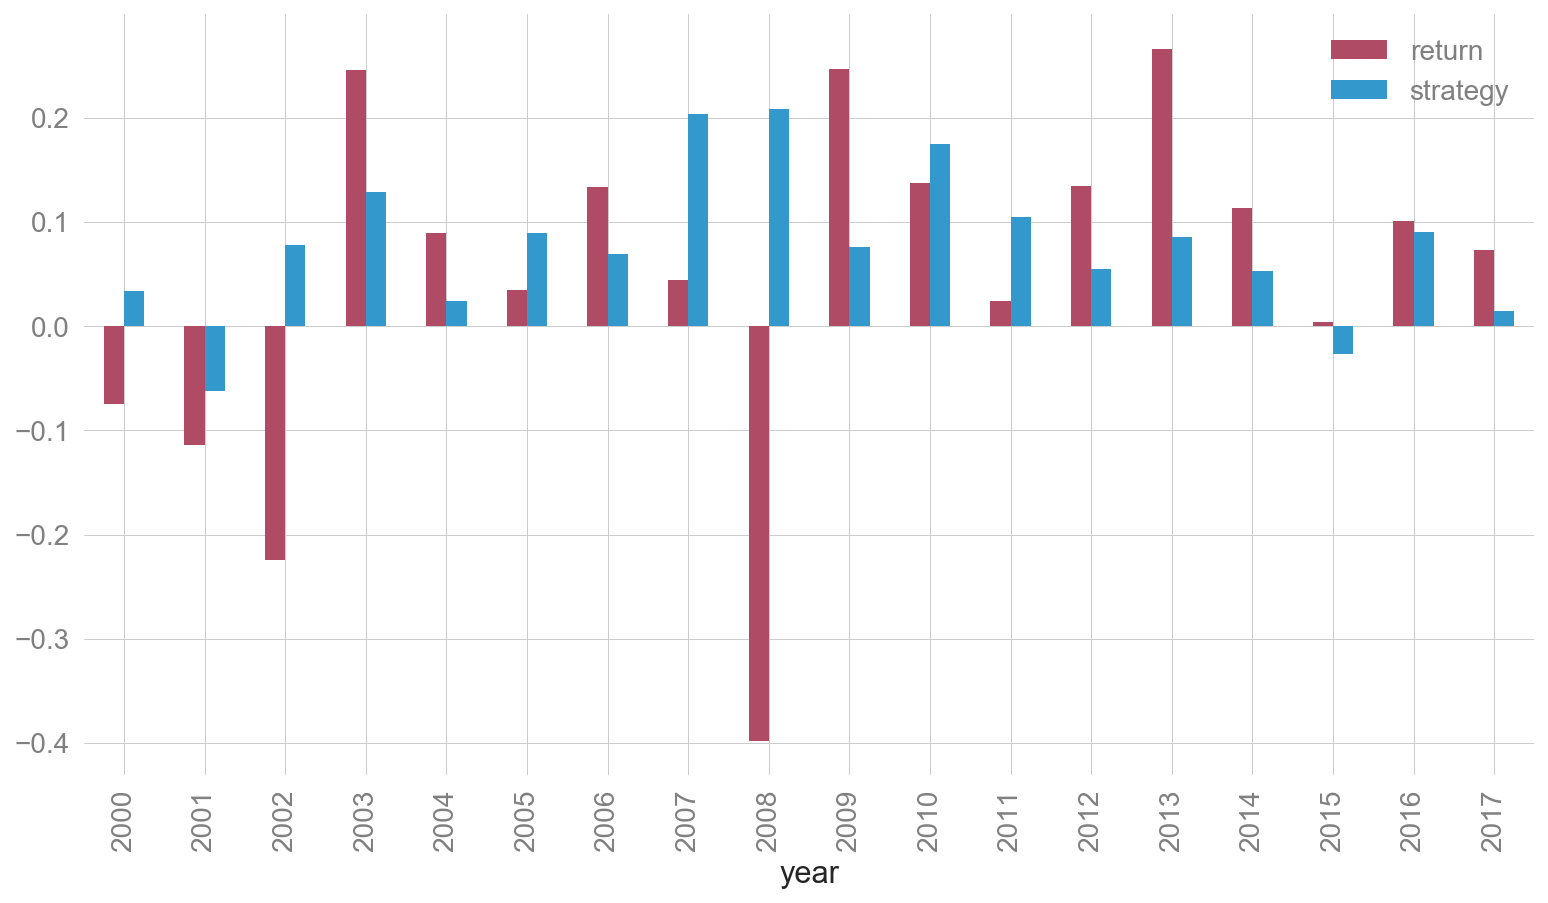

In [14]:
atw.sum_by_year(port).plot(kind='bar')

## Monthly Returns

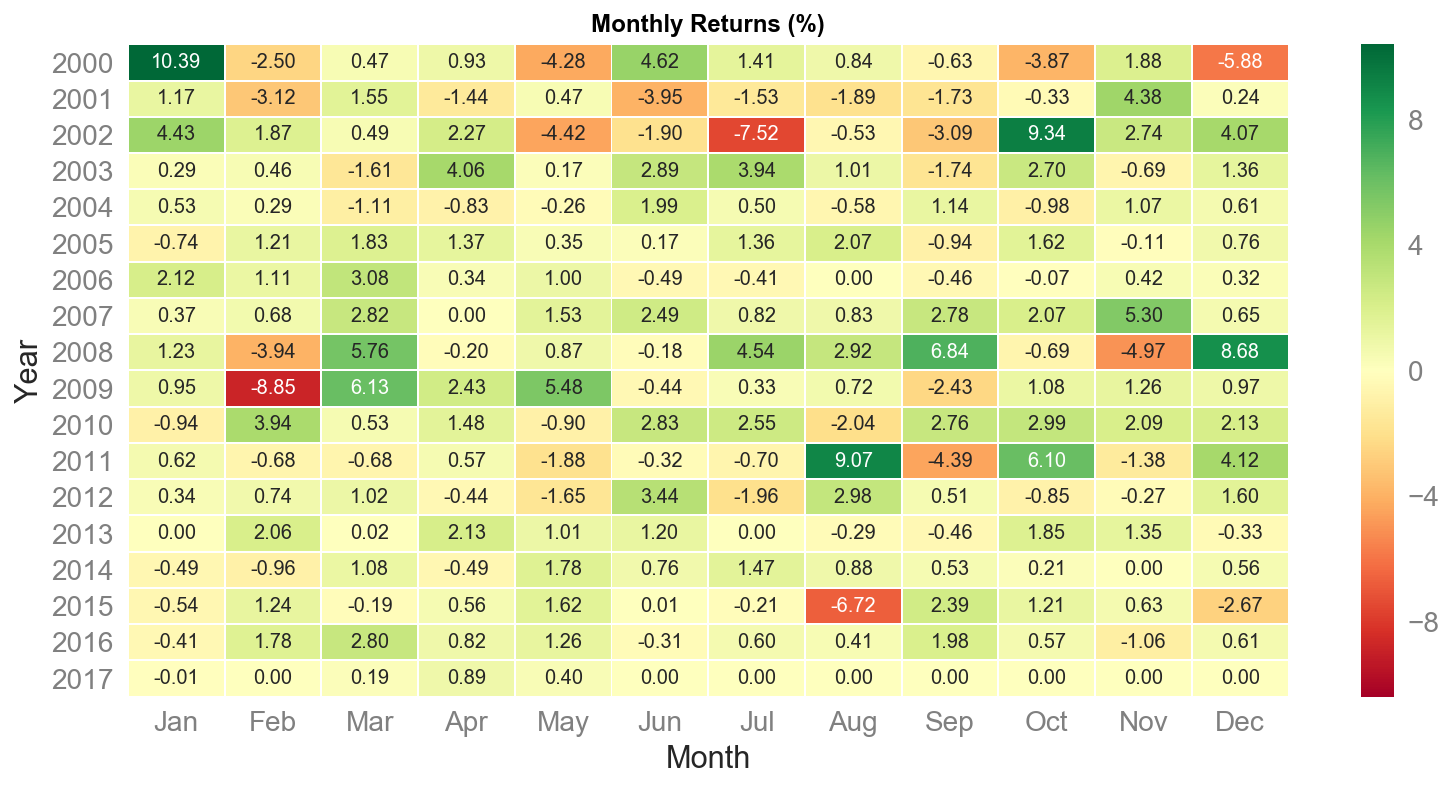

In [15]:
atw.monthly_returns_heatmap(port['strategy'])

---

# Optimizing Your Strategy

In [16]:
# split the data into training and testing sets
train, test = atw.train_test_split(spy, test_size=.2)

# Strategy Idea

- GO LONG where Fast SMA >= Slow SMA
- GO SHORT where Fast SMA < Slow SMA

In [17]:
port = pd.DataFrame(train)
port['ma1'] = port['close'].rolling(window=50).mean()
port['ma2'] = port['close'].rolling(window=100).mean()

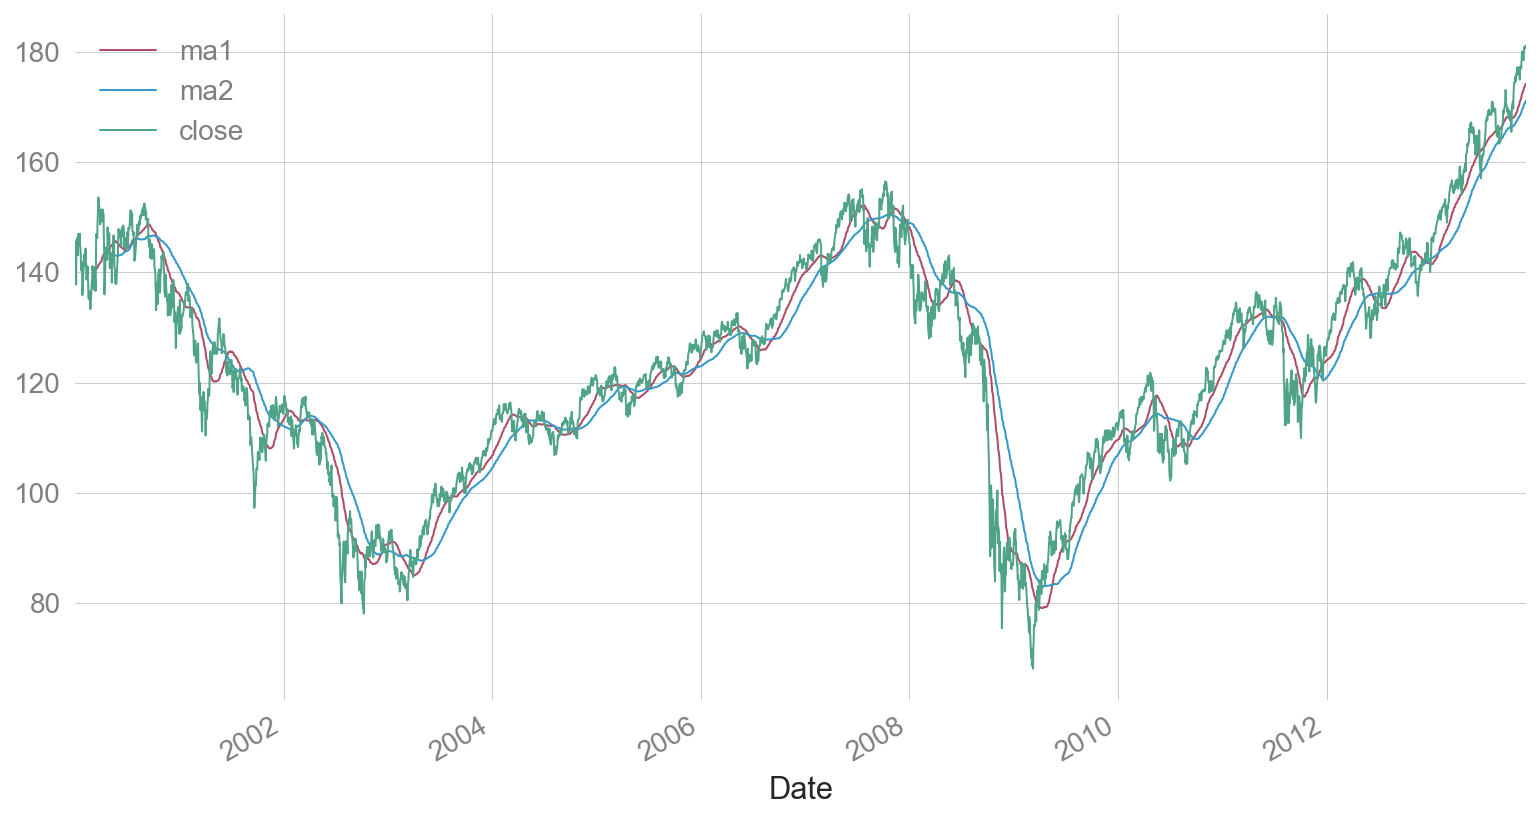

In [18]:
port[['ma1', 'ma2', 'close']].plot(linewidth=1)

### Run the strategy

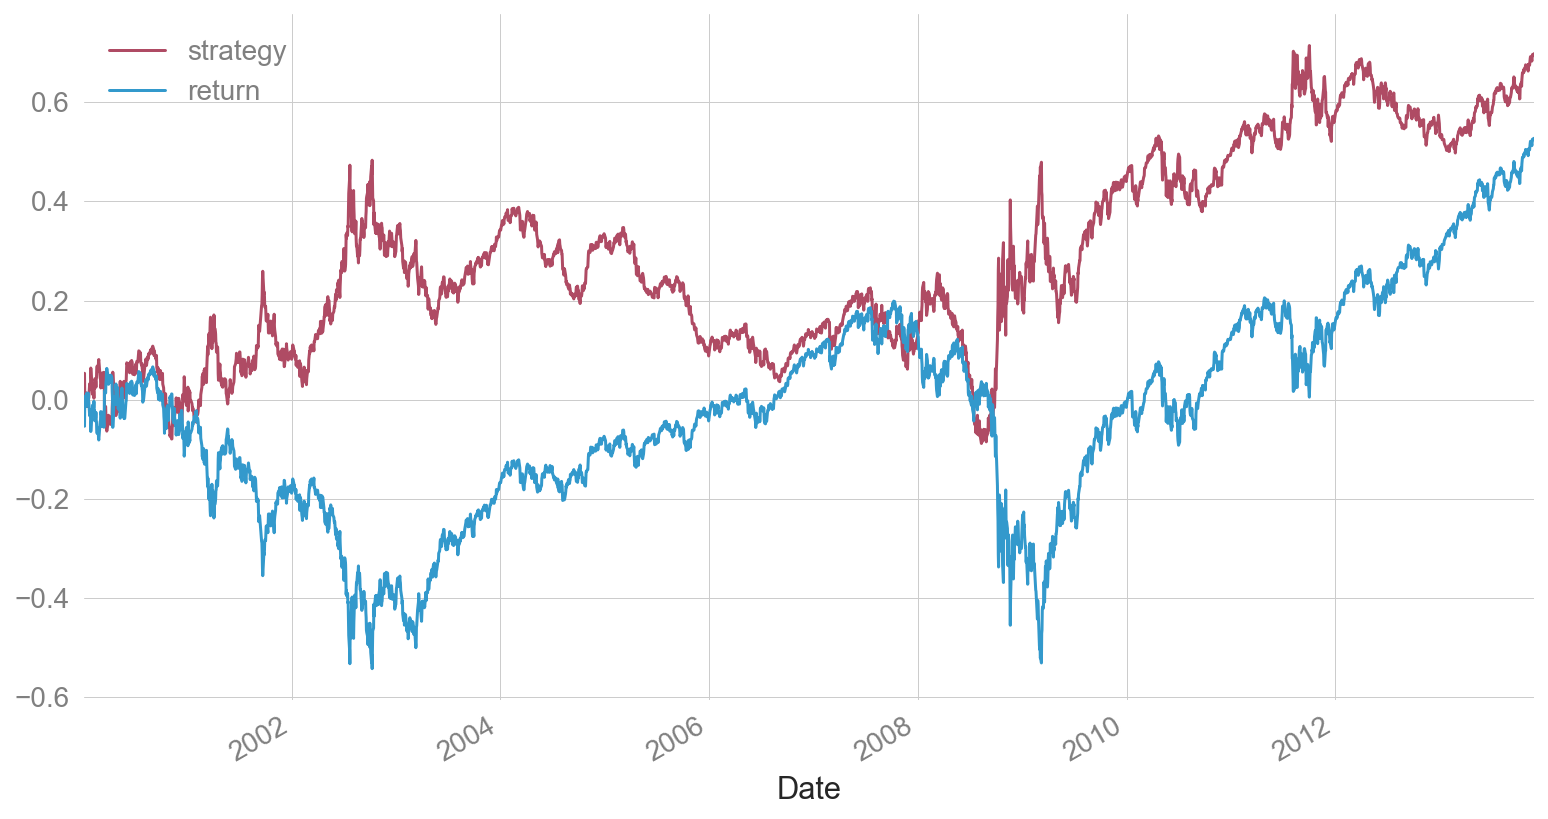

In [19]:
port['strategy'] = port['return'] * np.where(
    port['ma1'].shift(1) >= port['ma2'].shift(1), 1, -1)

port[['strategy', 'return']].cumsum().plot()

## Let's parameterize this strategy...

In [20]:
def ma_strategy(prices, ma_fast, ma_slow):

    # create dataframe
    df = pd.DataFrame(data={"price": prices})

    # returns column
    df['return'] = df['price'].pct_change(1)
    
    # parameters
    df['ma1'] = df['price'].rolling(window=ma_fast).mean()
    df['ma2'] = df['price'].rolling(window=ma_slow).mean()
    
    # strategy
    df['strategy'] = df['return'] * np.where(
        df['ma1'].shift(1) >= df['ma2'].shift(1), 1, -1)

    return df['strategy'].fillna(0)

### Set Fast / Slow MA Ranges

In [21]:
ma1 = np.linspace(5, 50, 20).astype(int)
ma2 = np.linspace(100, 200, 21).astype(int)

print("MA1 =", ma1)
print("MA2 =", ma2)

MA1 = [ 5  7  9 12 14 16 19 21 23 26 28 31 33 35 38 40 42 45 47 50]
MA2 = [100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
 190 195 200]


### Create metrics placeholder grids

In [22]:
sharpes = np.zeros((len(ma1), len(ma2)))
returns = np.zeros(sharpes.shape)
drawdowns = np.zeros(sharpes.shape)

In [23]:
timer.start()

# loop over ma1/ma2 combination and collect stats
for i1, ma1_val in enumerate(ma1):
    for i2, ma2_val in enumerate(ma2):
        pnl = ma_strategy(train['close'], ma1_val, ma2_val)

        sharpes[i1, i2] = atw.sharpe(pnl)
        returns[i1, i2] = sum(pnl)
        drawdowns[i1, i2] = atw.drawdown(pnl)['percent'].min()
        
timer.stop()


[*] Total runtime: 3.87 s


### Results stored in `sharpes`, `returns` and `drawdowns`

In [24]:
pd.DataFrame(sharpes).loc[:5, :5]

,0,1,2,3,4,5
0,0.097835,0.040829,0.083160,0.044427,0.048959,0.062550
1,0.050221,0.070163,0.114933,0.045142,0.034502,0.039792
2,0.171887,0.152859,0.105921,0.072443,0.091922,0.066654
3,0.244185,0.155257,0.152948,0.127774,0.172232,0.189197
4,0.237095,0.212248,0.205425,0.144578,0.203938,0.171783
5,0.252694,0.204388,0.167583,0.188267,0.181722,0.266684


## Sharpe Heatmap

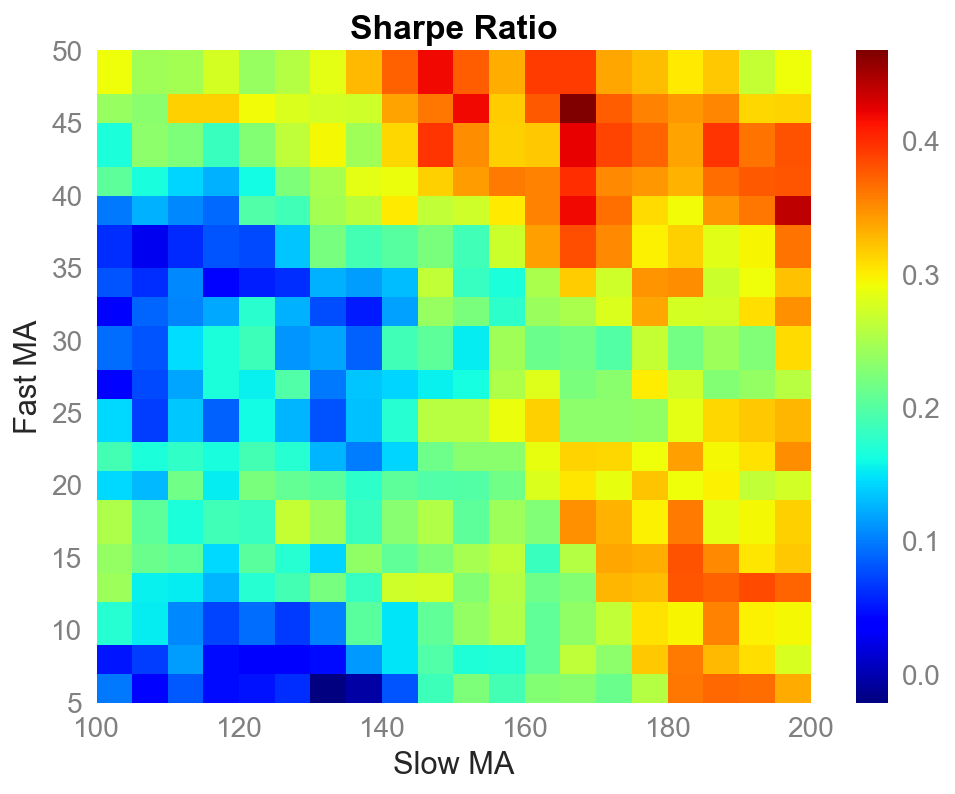

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.pcolormesh(ma1, ma2, sharpes.T, cmap="jet")
plt.title("Sharpe Ratio", fontweight="bold", color="black")
plt.xlabel("Fast MA")
plt.ylabel("Slow MA")
plt.colorbar()

## Quicker way :)

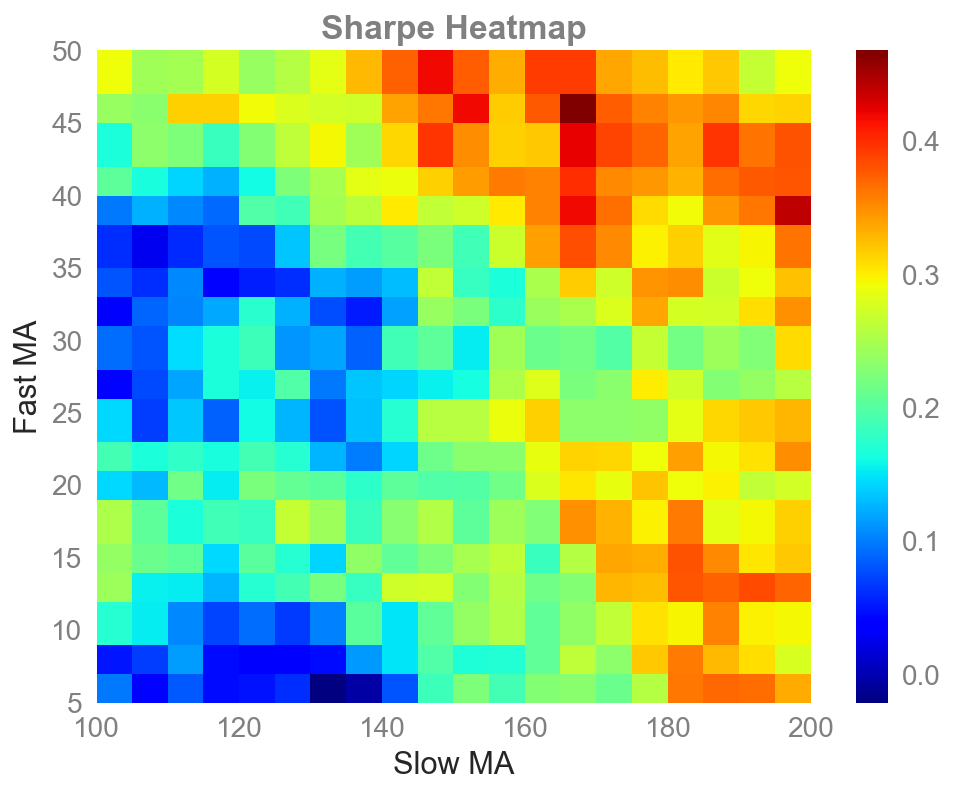

In [26]:
atw.colormap2d(x=ma1, y=ma2, res=sharpes, 
               x_title="Fast MA", y_title="Slow MA", 
               title="Sharpe Heatmap")

# Reveal best values

In [27]:
i1, i2 = np.unravel_index(sharpes.argmax(), sharpes.shape)
print('Optimal Fast MA = %.f' % ma1[i1])
print('Optimal Slow MA = %.f' % ma2[i2])

# or use:
# atw.unravel2d(x=ma1, y=ma2, res=sharpes)

Optimal Fast MA = 50
Optimal Slow MA = 200


# Are we rich yet?

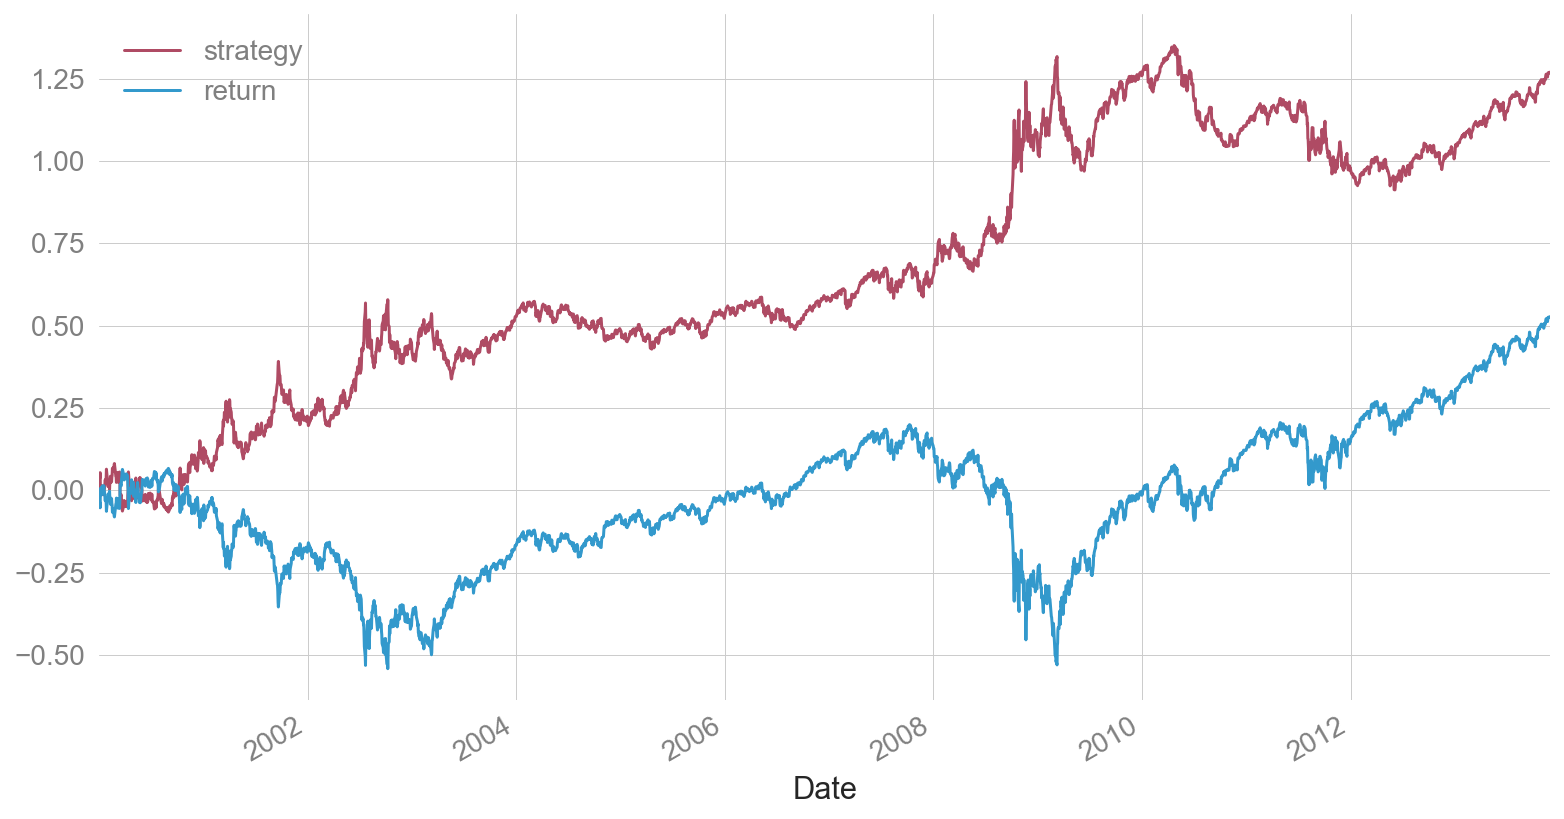

In [28]:
train_port = train[['close', 'return']].copy()
train_port['strategy'] = ma_strategy(train_port['close'], ma1[i1], ma2[i2])
train_port[['strategy', 'return']].cumsum().plot()

# Past performance is not indicative of future results

## Past performance is not indicative of future results

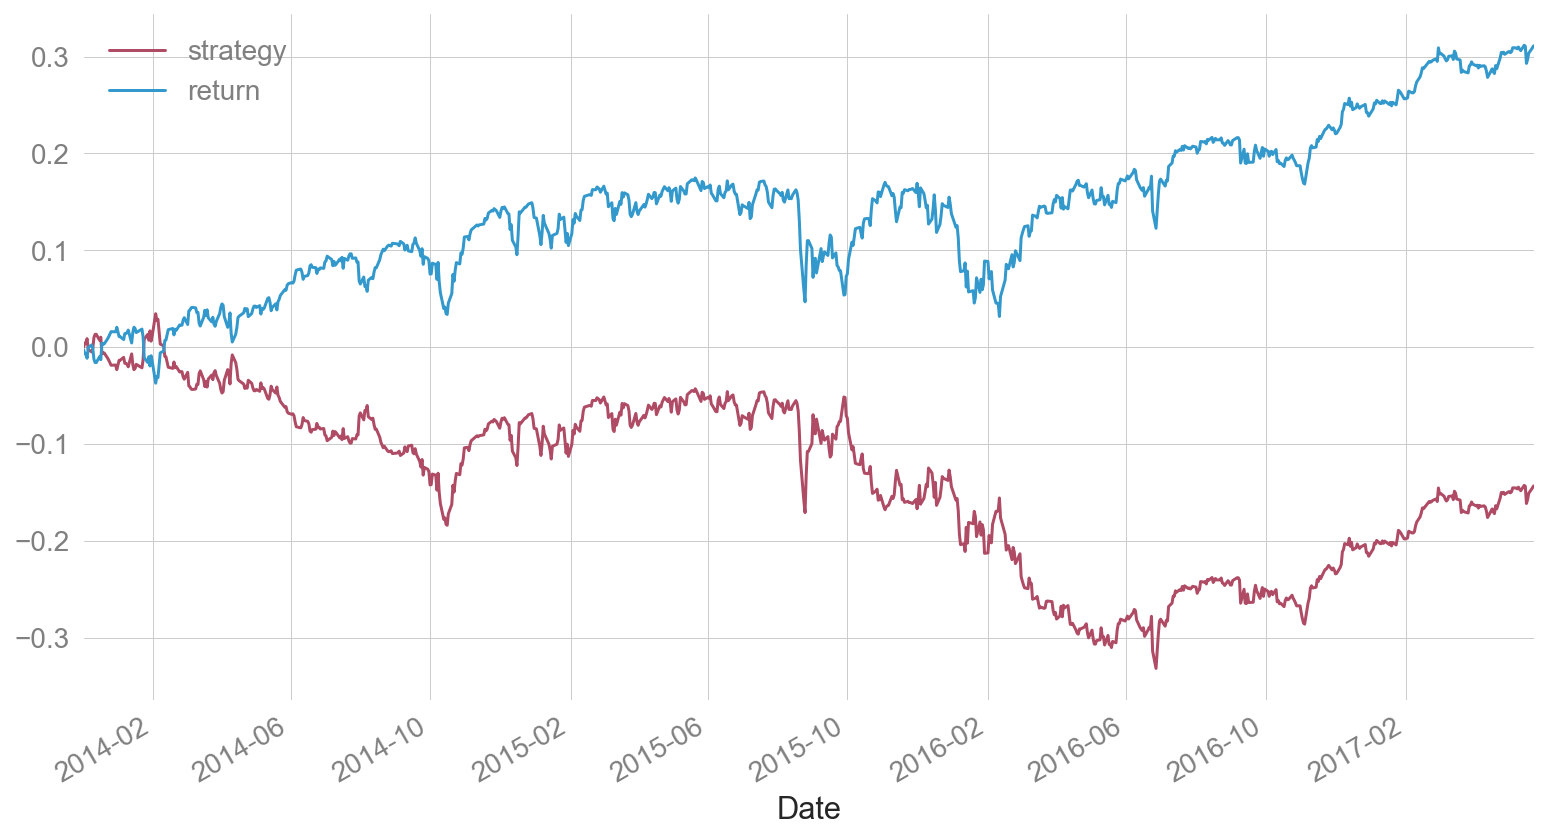

In [29]:
test_port = test[['close', 'return']].copy()
test_port['strategy'] = ma_strategy(test_port['close'], ma1[i1], ma2[i2])
test_port[['strategy', 'return']].cumsum().plot()

# Explore the relations between the different metrics

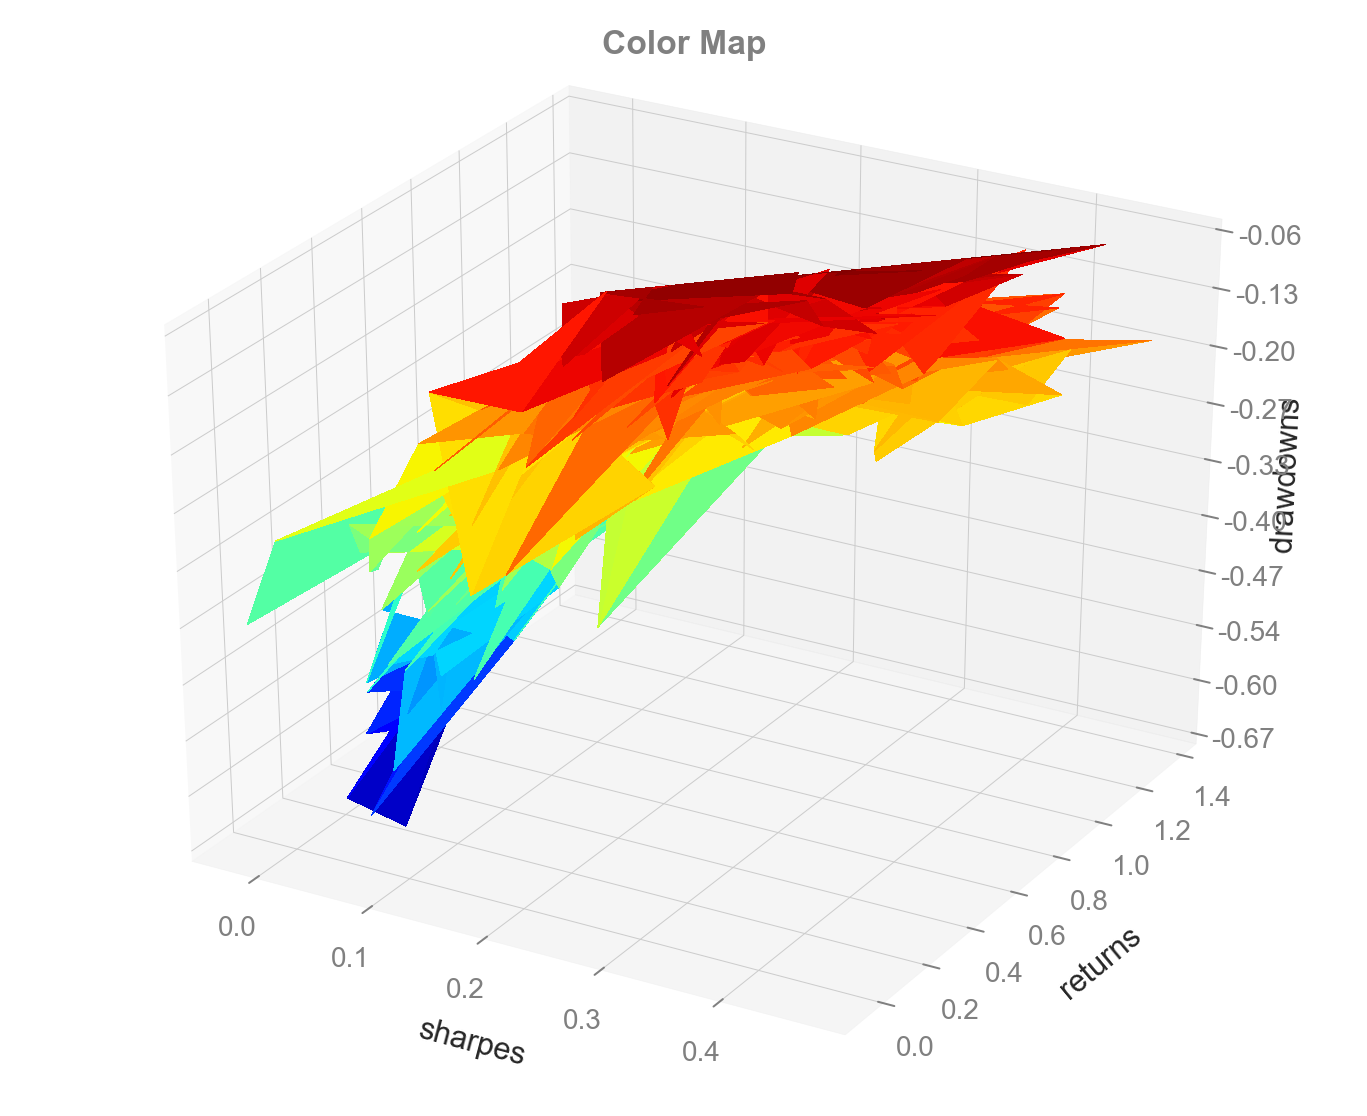

In [30]:
atw.colormap3d(sharpes, returns, drawdowns, 
               "sharpes", "returns", "drawdowns")

---

# Testing for robustness testing using Monte Carlo

## Testing for robustness testing using Monte Carlo

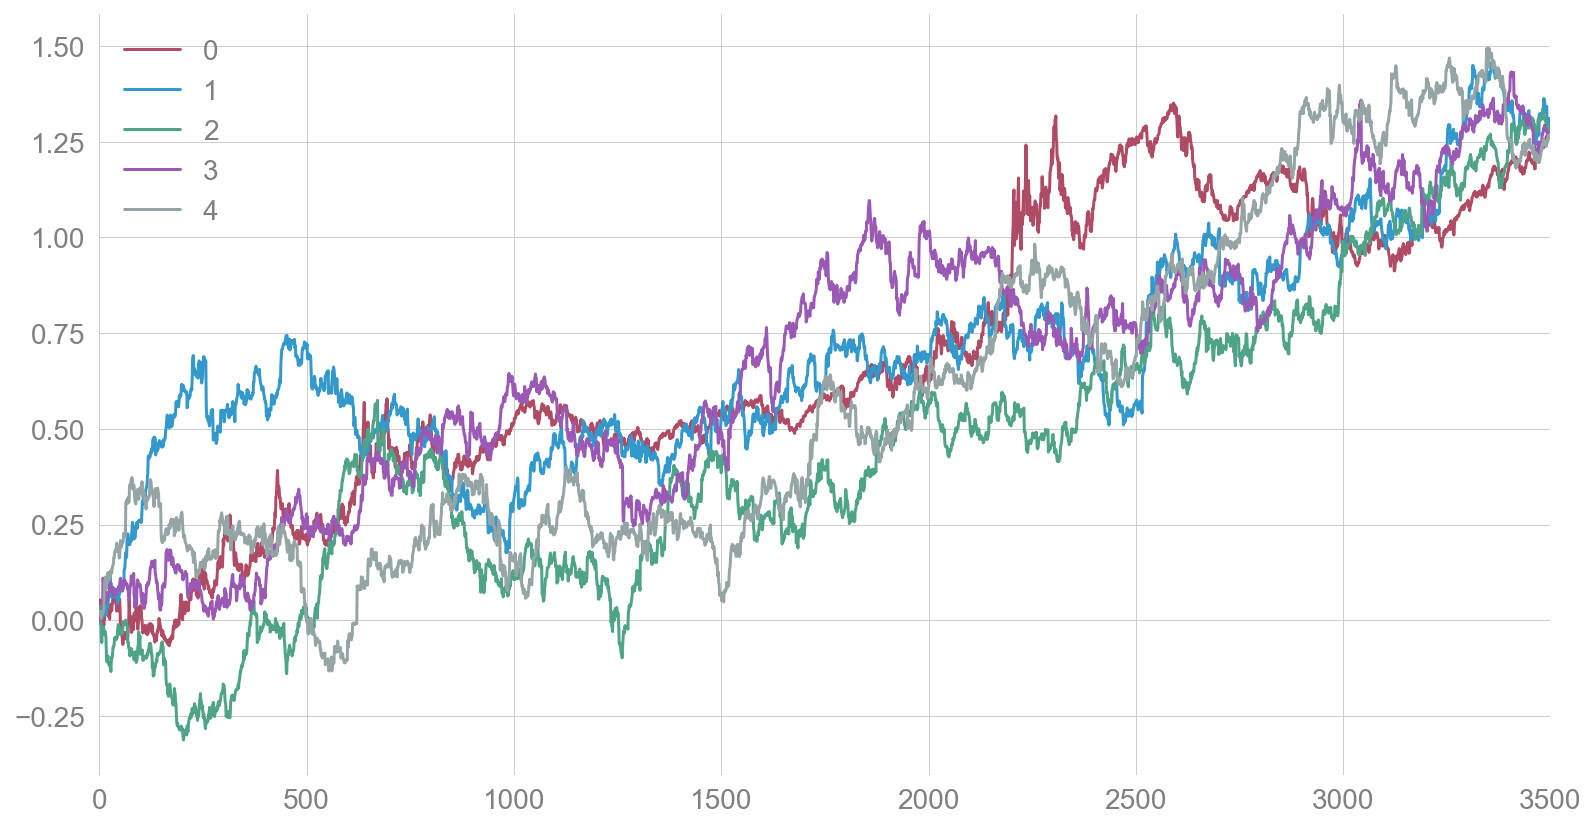

In [31]:
# I'll be using the "good" backtest for this example :)
returns = train_port['strategy']

results = [returns.values]
for i in range(1, 5):
    results.append(returns.sample(frac=1).values)
mc = pd.DataFrame(results).fillna(0).transpose()

mc.cumsum().plot()

## Quicker way :)

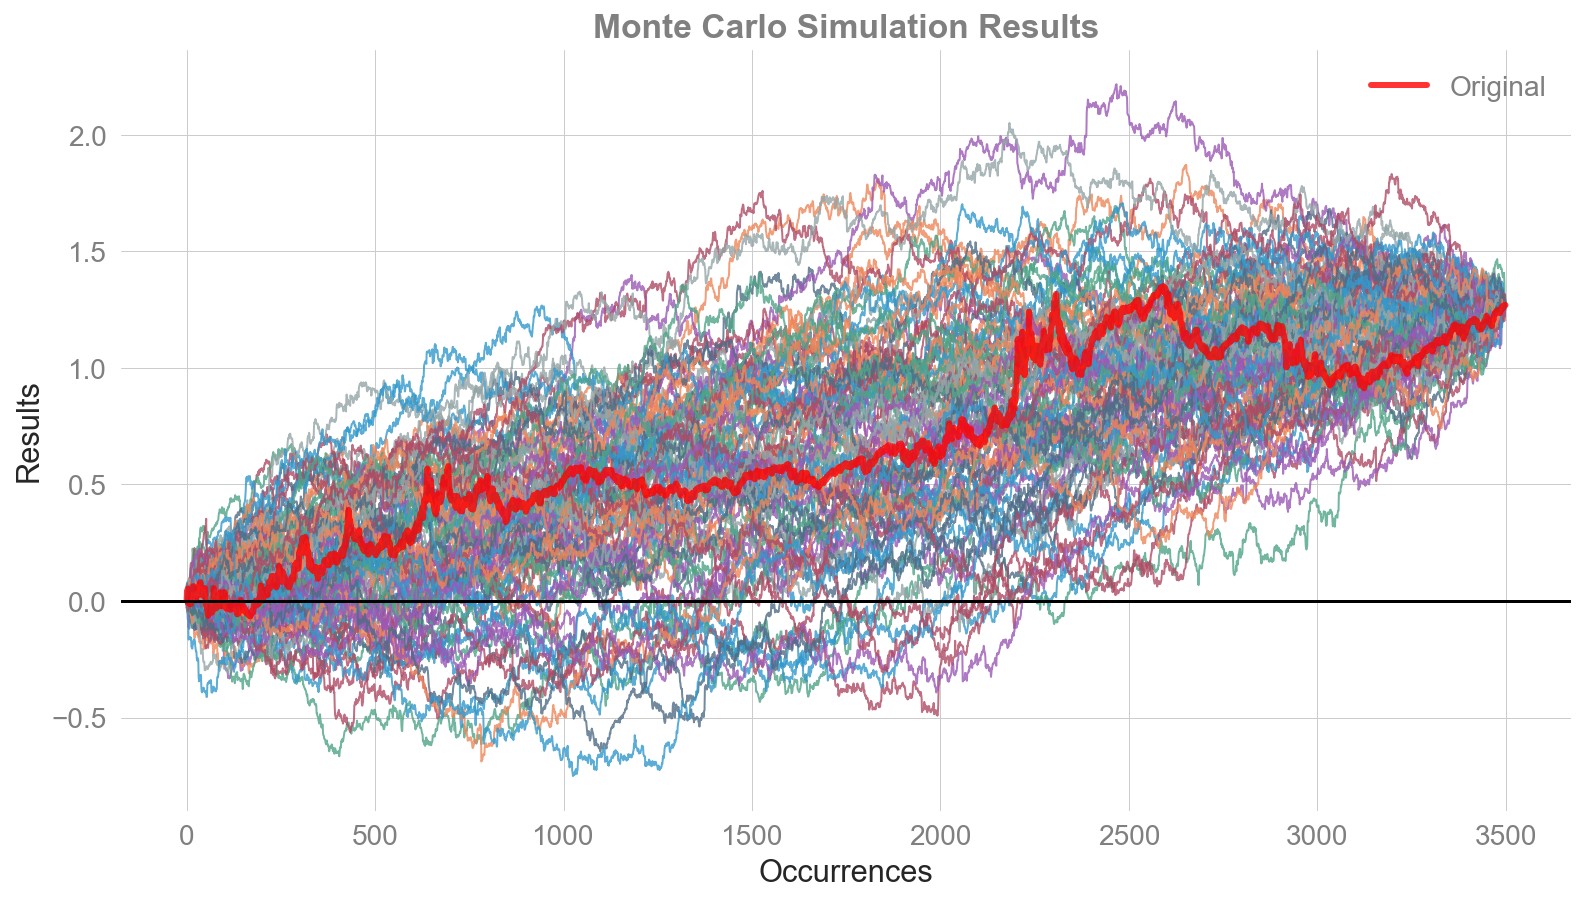

In [32]:
mc = atw.montecarlo(returns, sims=100, bust=-0.2, goal=.5)
mc.plot()

## Monte Carlo statistics

In [33]:
mc.stats

{'bust': 0.35,
 'goal': 0.65,
 'max': 1.2691018483020047,
 'maxdd': -0.7502588293564848,
 'mean': 1.2691018483020005,
 'median': 1.2691018483020007,
 'min': 1.2691018483019953,
 'std': 1.7433890469550465e-15}

In [34]:
mc.maxdd

{'max': -0.0019278062737281276,
 'mean': -0.1918106686859642,
 'median': -0.12824269426091944,
 'min': -0.7502588293564848,
 'std': 0.1717092638984963}